# Test alignment procedure
This file is used to test the alignment procedure using the center of the fiber core as a reference and the reflected laser beam.

In [1]:
import os
from time import sleep
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cv2

import matplotlib

matplotlib.rc('figure', figsize=(15, 10))

DATA_DIR = "D:\\Data\\Dispertech\\Centroids"

In [2]:
from dispertech.models.electronics.arduino import ArduinoModel
from dispertech.models.cameras.basler import Camera
from experimentor import Q_
from experimentor.models.decorators import make_async_thread

In [3]:
ard = ArduinoModel(0)
ard.initialize()
ard.laser_power(30)

In [4]:
cam = Camera('da')
cam.initialize()

414.5970029020831 833.2761678044347


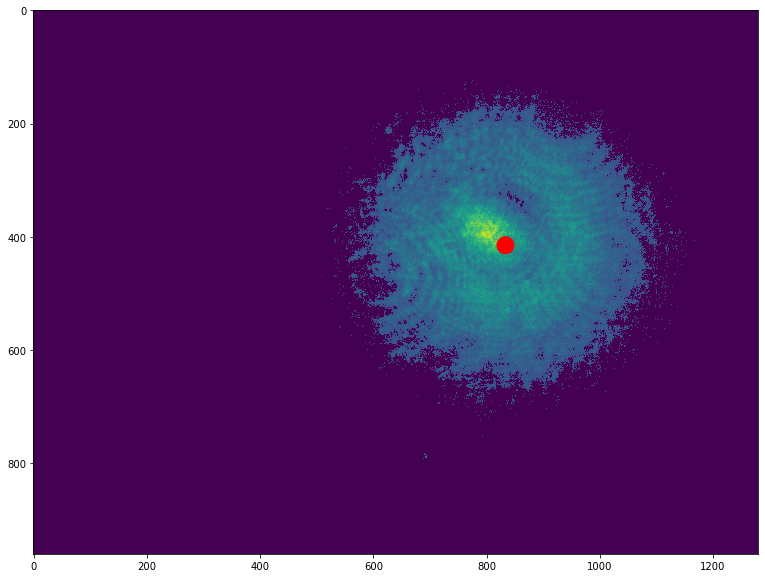

In [93]:
# ard.move_mirror(0, 0, 2)
ard.laser_power(30)
cam.set_exposure(Q_('.01ms'))
cam.trigger_camera()
img = cam.read_camera()[0]
mask = img>np.mean(img.reshape(img.size,1))+np.std(img.reshape(img.size,1))
test_img = mask*np.ones(img.shape, dtype=np.uint8)*2**8
M = cv2.moments(test_img)
cx = M['m10']/M['m00']
cy = M["m01"] / M["m00"]
print(cx, cy)
fig, ax = plt.subplots(1)
ax.imshow(mask.T*img.T)
circ = Circle((cy, cx), radius=15,color='red')
ax.add_patch(circ)

In [97]:
def acquire_from_camera(data, folder):
    if not os.path.isdir(os.path.join(data_folder, 'image_data', folder)):
        os.makedirs(os.path.join(data_folder, 'image_data', folder))
    for i in range(accumulations_per_position+1):
        cam.trigger_camera()
        img = cam.read_camera()[0]
        if i==0: continue
        mask = img>np.mean(img.reshape(img.size,1))+np.std(img.reshape(img.size,1))
        M = cv2.moments(mask*img)
        cx = M['m10']/M['m00']
        cy = M["m01"] / M["m00"]
        data[-1][0].append(cx)
        data[-1][1].append(cy)
    np.save(os.path.join(data_folder, 'image_data', folder, f'img_{i}'), img)

In [98]:
def make_plots(data, folder):
    fig, ax = plt.subplots(nrows=1, ncols=2)

    dt = np.array(data)
    C = np.zeros((2,len(data)))
    for i in range(len(data)):
        ax[0].plot(data[i][0],data[i][1], 'o')
        C[0][i] = np.mean(data[i][0])
        C[1][i] = np.mean(data[i][1])

    ax[1].plot(C[0,:],C[1][:], '.-')
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    fig.suptitle(f'Speed: {speed}', fontsize=16)
    ax[0].set_title(f'Calculated centroid for {accumulations_per_position} acquisition')
    ax[0].set(xlabel='Centroid position (px)', ylabel='Centroid position (px)')
    ax[1].set_title('Averaged centroid')
    ax[1].set(xlabel='Centroid position (px)', ylabel='Centroid position (px)')

    plt.savefig(os.path.join(folder, f'centroids_speed_{speed}.png'))

Acquiring: laser power: 0 - mirror speed: 1
Acquiring: laser power: 0 - mirror speed: 2
Acquiring: laser power: 0 - mirror speed: 4
Acquiring: laser power: 0 - mirror speed: 8
Acquiring: laser power: 0 - mirror speed: 16
Acquiring: laser power: 10 - mirror speed: 1
Acquiring: laser power: 10 - mirror speed: 2
Acquiring: laser power: 10 - mirror speed: 4
Acquiring: laser power: 10 - mirror speed: 8
Acquiring: laser power: 10 - mirror speed: 16
Acquiring: laser power: 20 - mirror speed: 1
Acquiring: laser power: 20 - mirror speed: 2
Acquiring: laser power: 20 - mirror speed: 4
Acquiring: laser power: 20 - mirror speed: 8
Acquiring: laser power: 20 - mirror speed: 16
Acquiring: laser power: 30 - mirror speed: 1
Acquiring: laser power: 30 - mirror speed: 2
Acquiring: laser power: 30 - mirror speed: 4
Acquiring: laser power: 30 - mirror speed: 8
Acquiring: laser power: 30 - mirror speed: 16


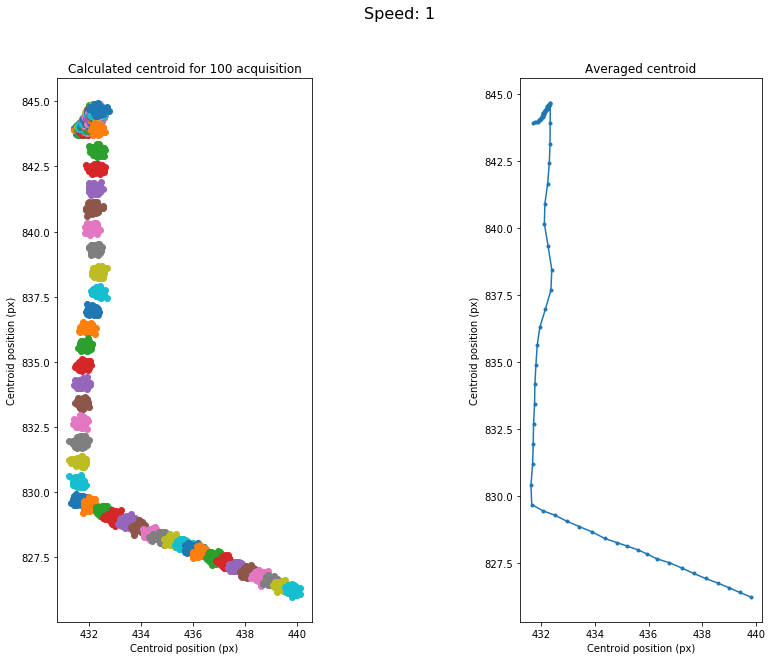

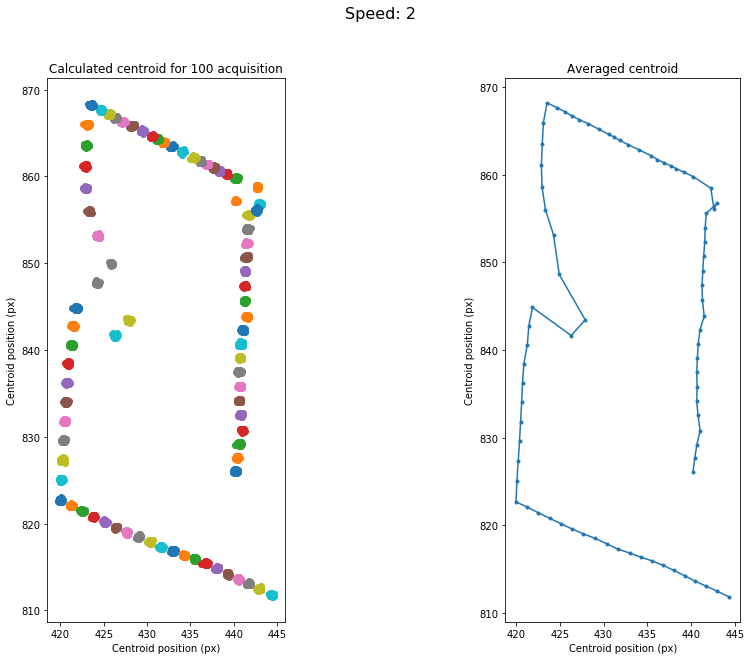

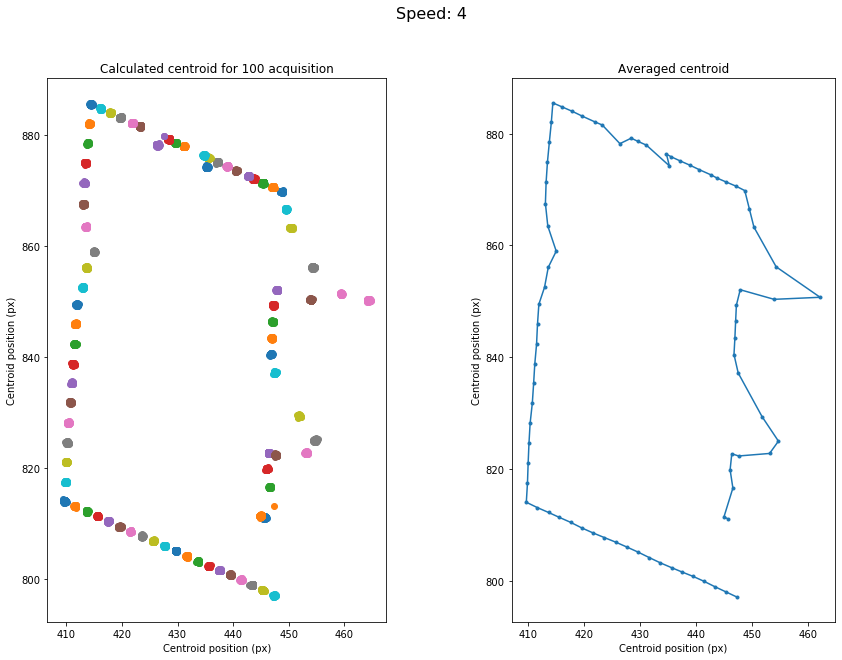

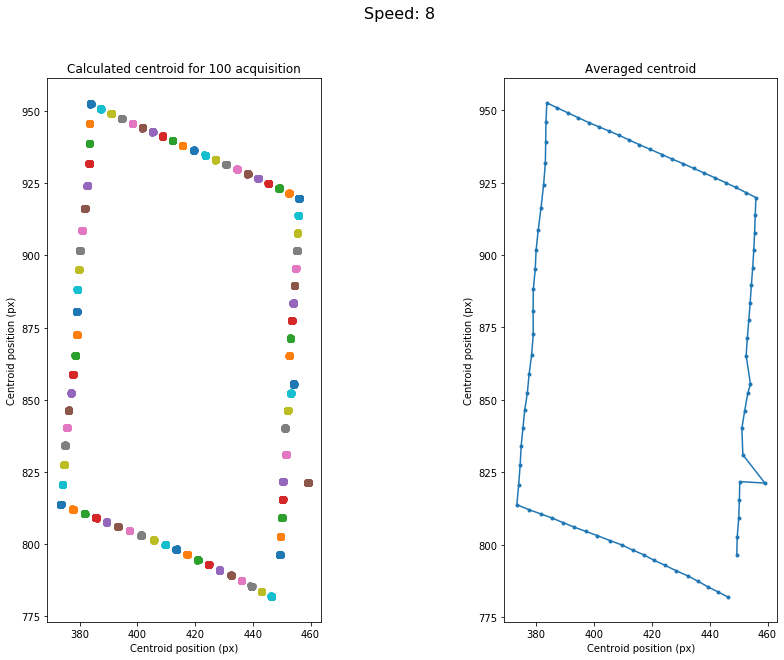

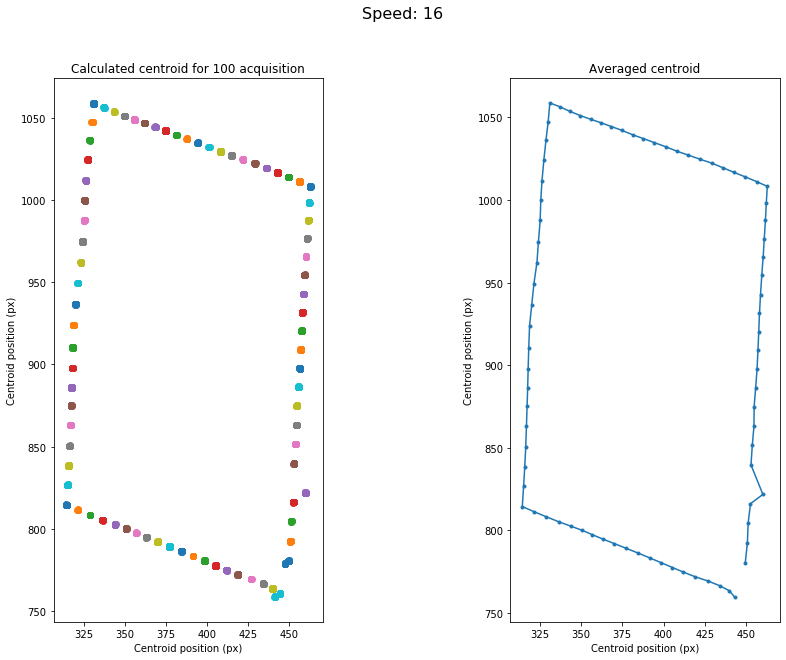

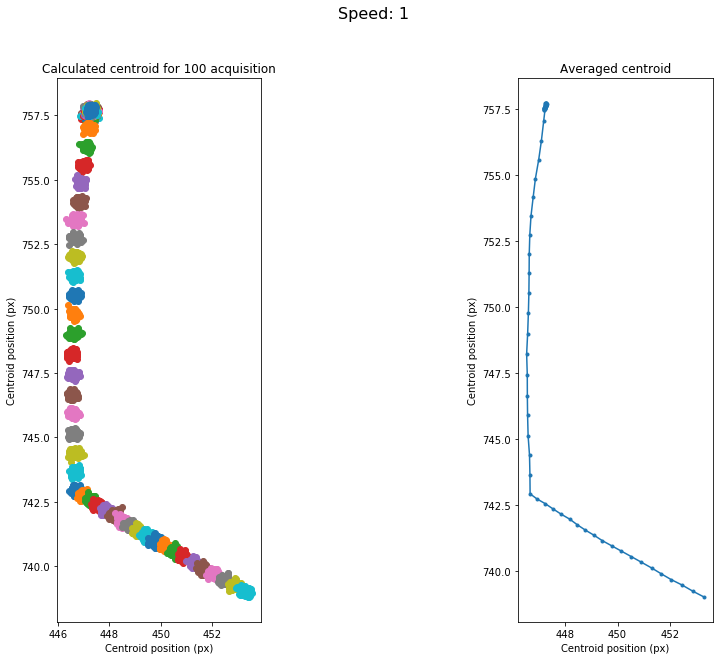

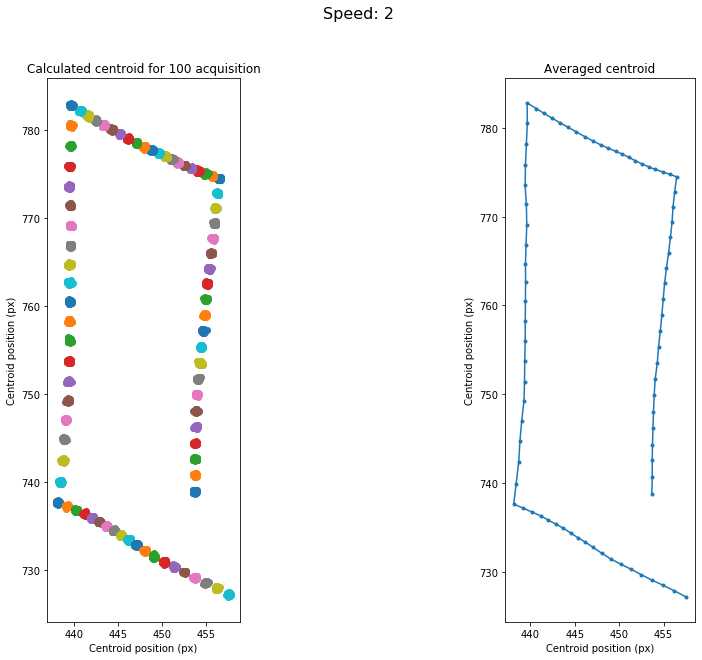

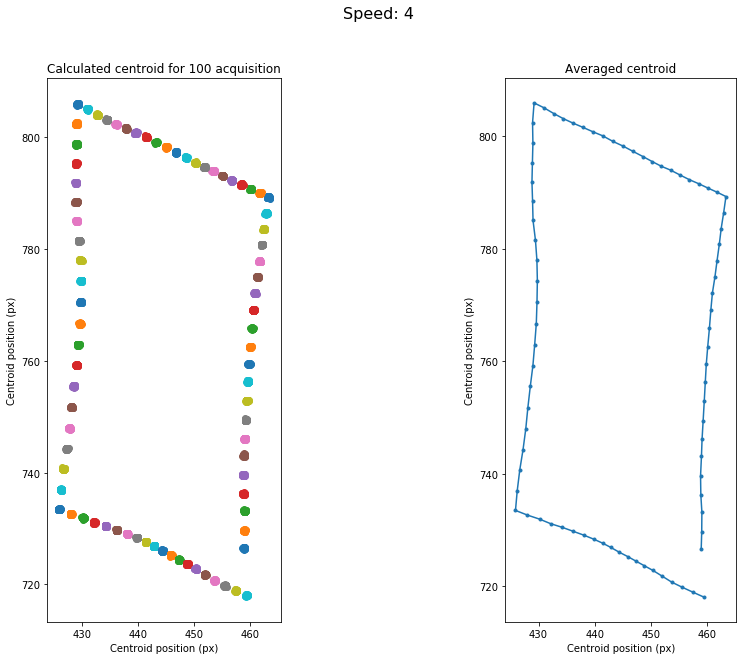

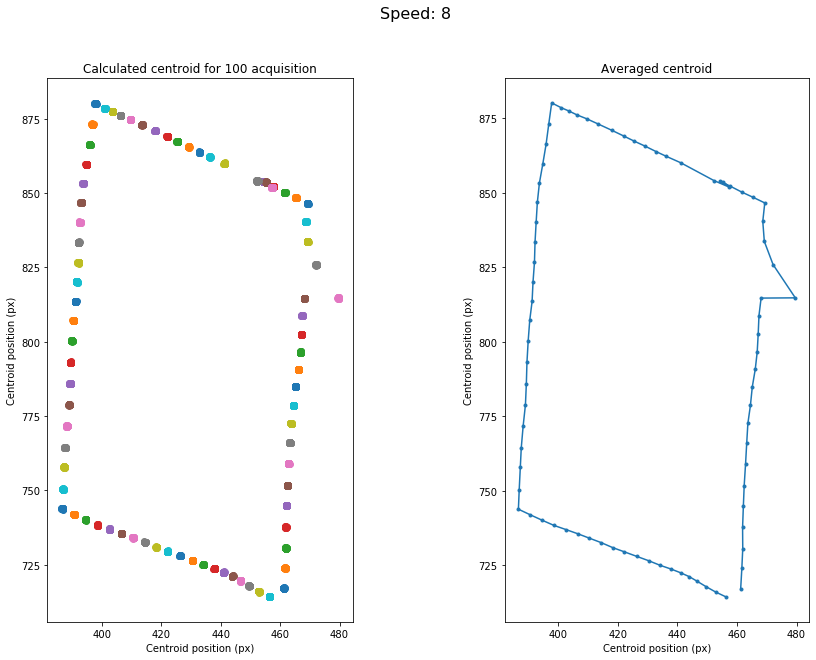

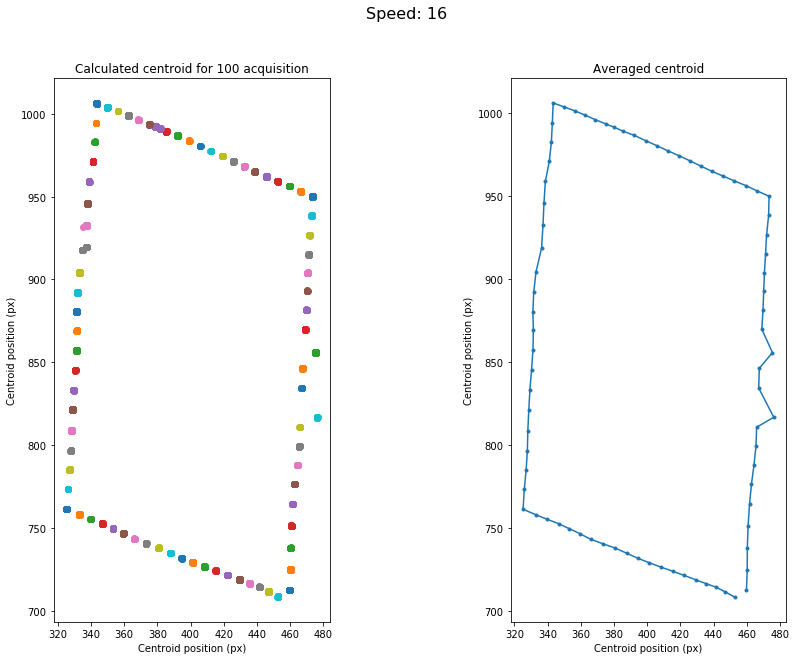

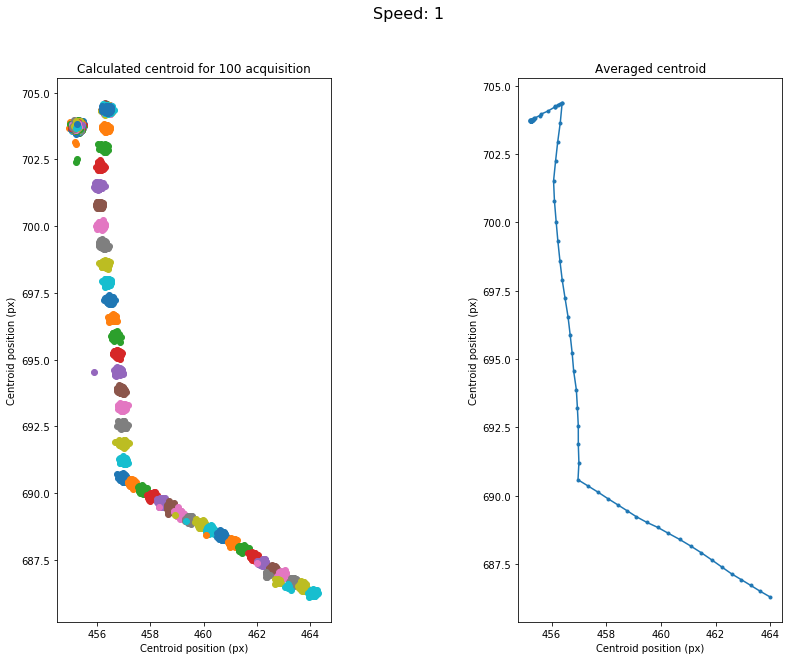

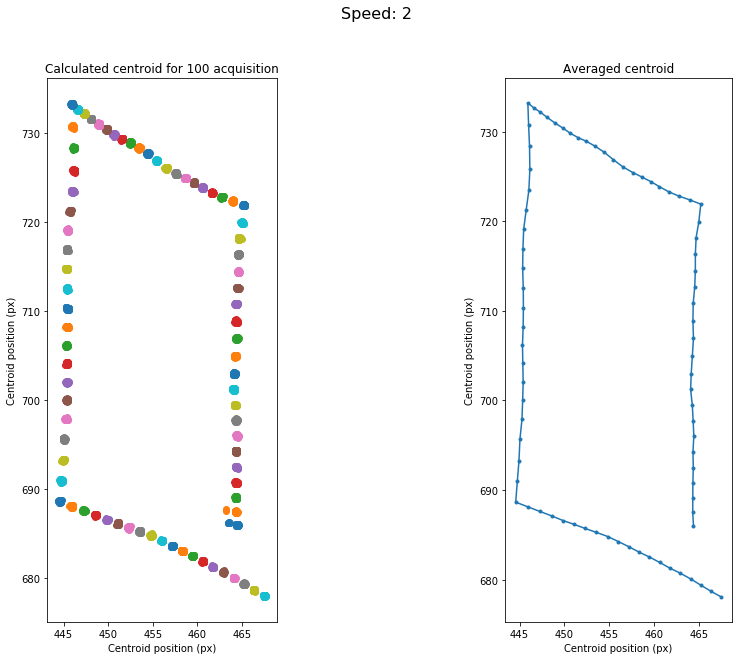

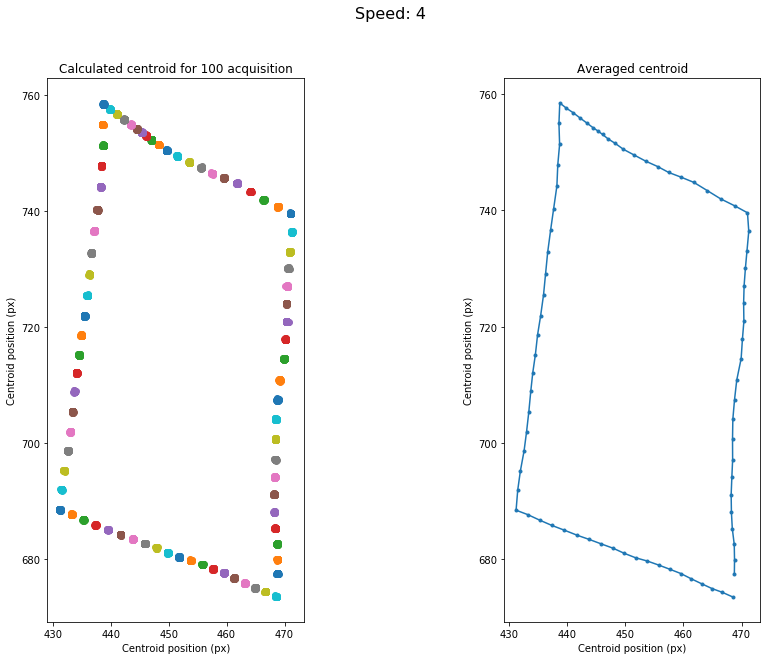

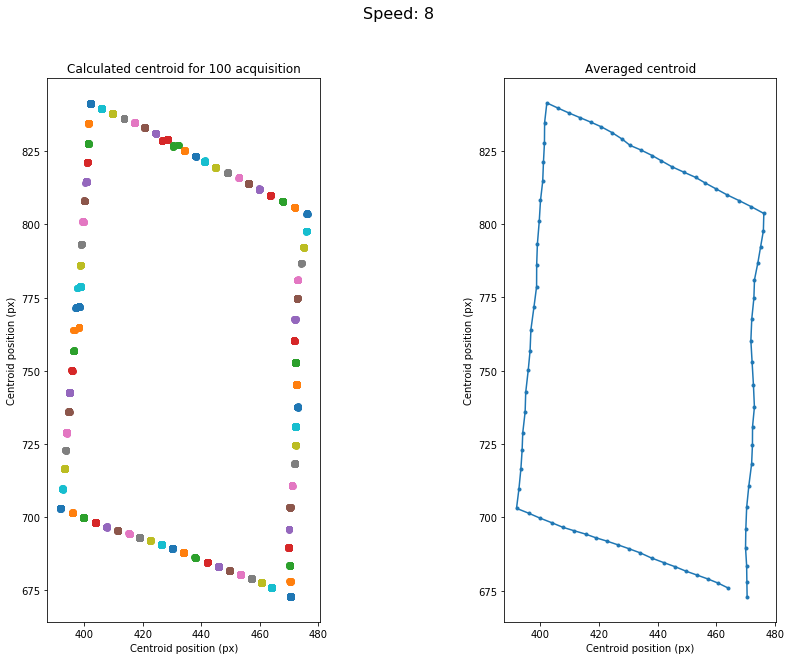

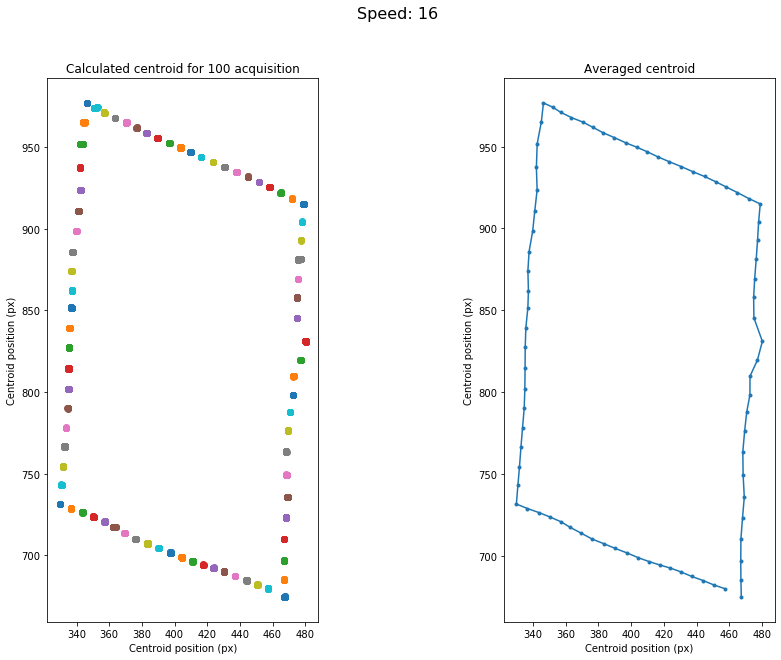

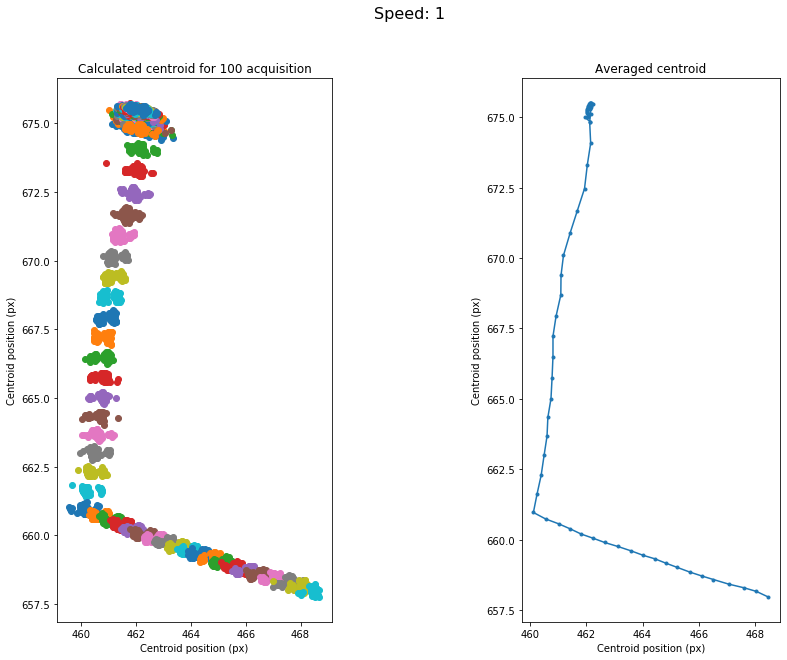

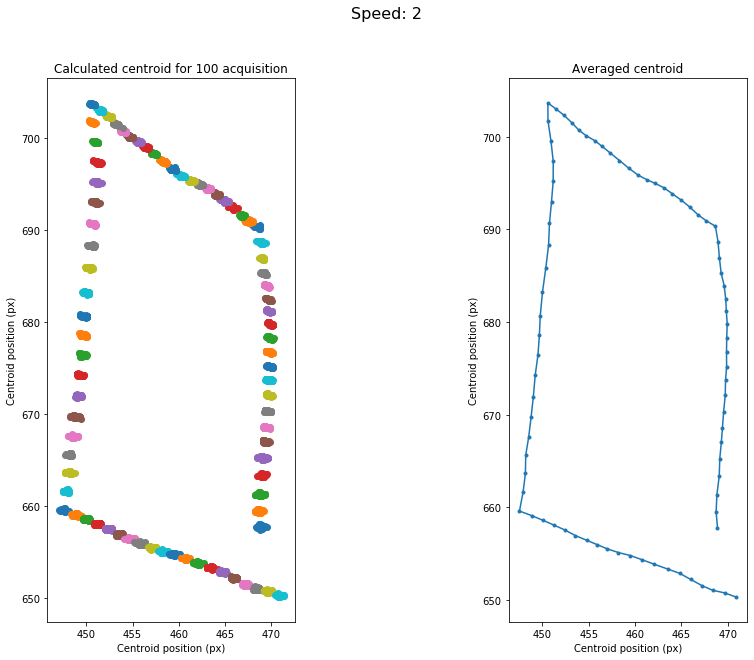

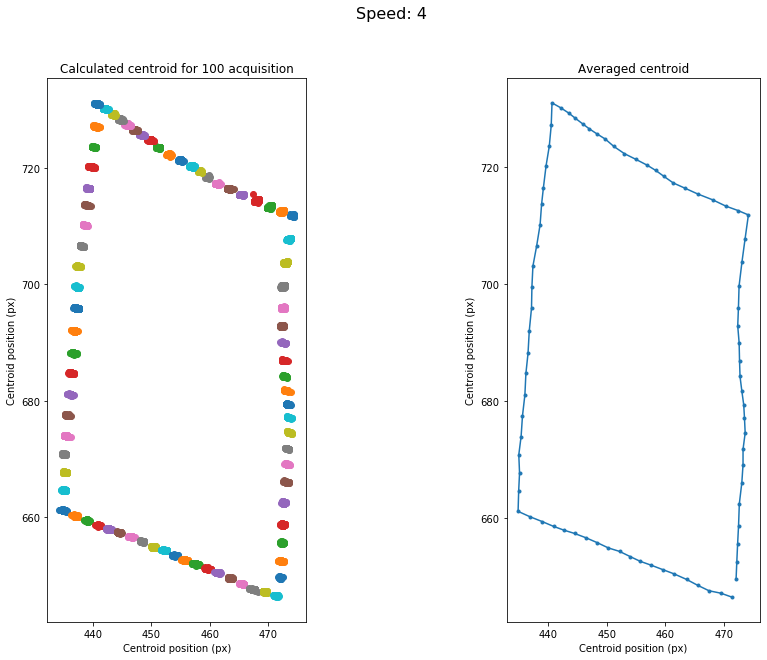

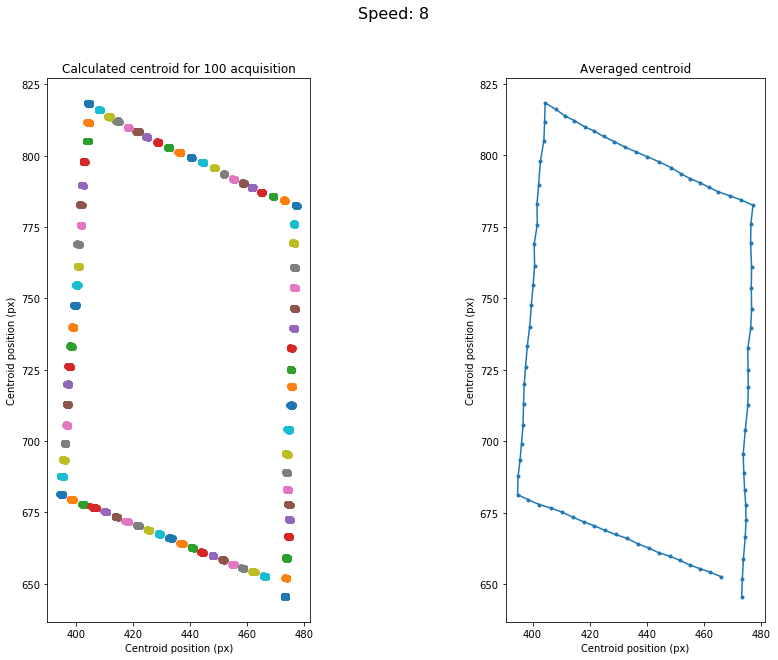

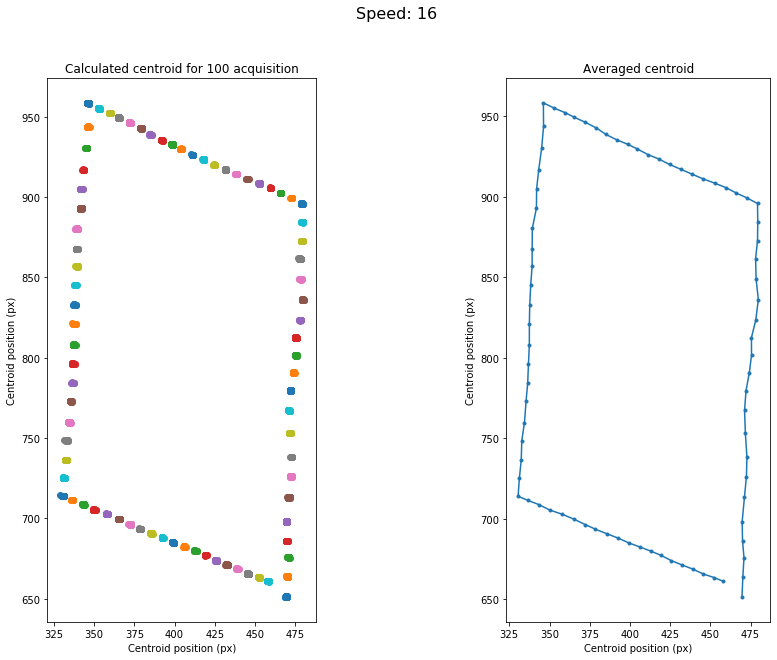

In [99]:
speeds = [1, 2, 4, 8, 16]
laser_powers = [0, 10, 20, 30]
max_data_points = 20
accumulations_per_position = 100
exposure_time = Q_('.01ms')

cam.set_exposure(exposure_time)
for power in laser_powers:
    data_folder = os.path.join(DATA_DIR, f'laser_power_{power}')
    if not os.path.isdir(data_folder):
        os.mkdir(data_folder)
        os.mkdir(os.path.join(data_folder, 'image_data'))
    ard.laser_power(power)
    for speed in speeds:
        print(f'Acquiring: laser power: {power} - mirror speed: {speed}' )
        data = []
        for i in range(max_data_points):
            data.append(([],[]))
            acquire_from_camera(data, f'{speed}_12_{i}')
            ard.move_mirror(speed, 1, 2)
        for i in range(max_data_points):
            data.append(([],[]))
            acquire_from_camera(data, f'{speed}_11_{i}')
            ard.move_mirror(speed, 1, 1)
        for i in range(max_data_points):
            data.append(([],[]))
            acquire_from_camera(data, f'{speed}_02_{i}')
            ard.move_mirror(speed, 0, 2)
        for i in range(max_data_points):
            data.append(([],[]))
            acquire_from_camera(data, f'{speed}_01_{i}')
            ard.move_mirror(speed, 0, 1)
        make_plots(data, data_folder)

In [ ]:
ard.move_mirror(10, 1, 2)

In [91]:
test_img = mask*np.ones(img.shape, dtype=np.uint8)*2**8
circles = cv2.HoughCircles(test_img,cv2.HOUGH_GRADIENT,1,20,param1=50,param2=30,minRadius=100,maxRadius=0)

error: OpenCV(4.2.0) ..\modules\imgproc\src\hough.cpp:1728: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'cv::HoughCircles'


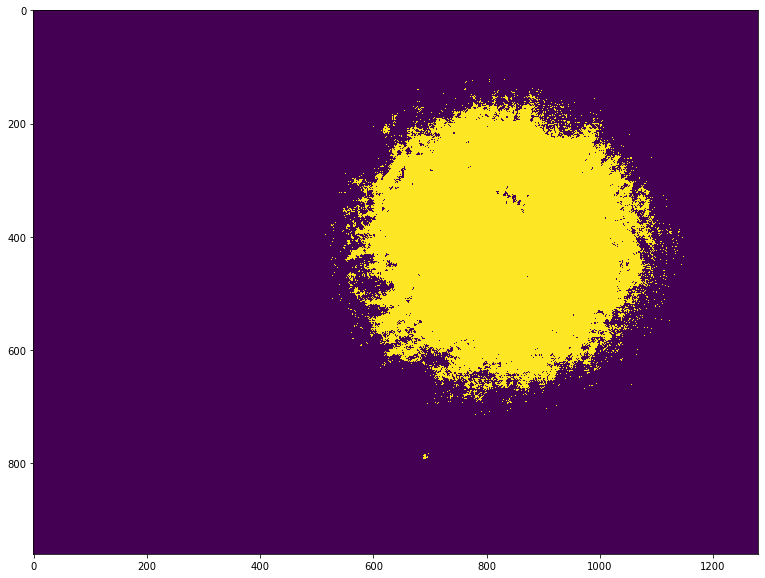

In [92]:
fig, ax = plt.subplots(1)
ax.imshow(test_img.T)
# for i in range(circles.shape[1]):
#     cx = circles[0, i, 0]
#     cy = circles[0, i, 1]
#     rad = circles[0, i, 2]
#     circ = Circle((cy, cx), radius=rad,color='red')
#     ax.add_patch(circ)


In [67]:
circles[0,1,1]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [58]:
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('detected circles',cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

TypeError: Expected Ptr<cv::UMat> for argument 'img'

In [20]:
im2 = cv2.medianBlur(img,5)

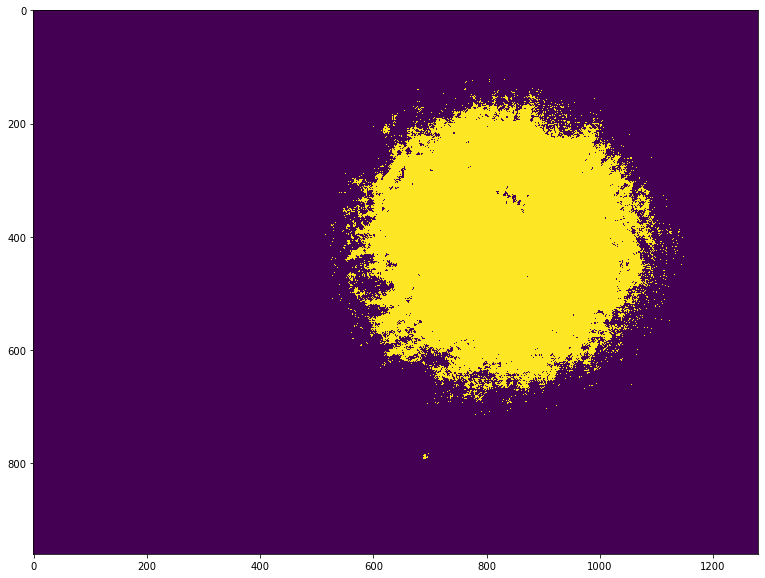

In [24]:
plt.imshow(mask.T)

In [23]:
type(mask)

numpy.ndarray